# Physics informed relevant information simulation (PIRIS)
**Comparación con el artículo de DFT**


# Librerias y Constantes

In [1]:
#Importamos ls librerias necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import tensorflow_probability as tfp
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe_connected'  # más estable en algunos entornos

2025-06-05 22:13:10.073327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749161590.455556      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749161590.563157      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Definimos las constantes a utilizar

a = 1.863  #Distancia de enlace Zn-O (A)
beta = 30*np.pi/180 #angulo de proyeccion de los lados del hexágono sobre el eje x en radianes
dist_x = 2*a*np.cos(beta) # distancia entre puntos en el eje x
dist_y = a*np.sin(beta) # distancia entre puntos en el eje y
offset_x = dist_x / 2 #offset de las filas impares a partir de la tercera fila
cols = 6# Número de columnas y filas
rows = 6
#Parametros del potencial L-J
SigmaO = 3.71 #Radio de vanderwalls del Oxigeno (A)
EpsilonO = 1.736 #Fondo del pozo del Oxigeno (kj/mol)
SigmaNi = 2.834 #Radio de vanderwalls del Niquel (A)
EpsilonNi = 0.0628 #Fondo del pozo Niquel (kj/mol)
SigmaZn = 4.045 #Radio de vanderwalls del Zinc (A)
EpsilonZn = 0.23 #Fondo del pozo Zinc (kj/mol)
SigmaO_Ni = (SigmaO+SigmaNi)/2 #Constante sigma de interacción cruzada O-Ni 
EpsilonO_Ni = np.sqrt(EpsilonO*EpsilonNi) #Constante epsilon de interacción cruzada O-Ni 
SigmaZn_Ni = (SigmaZn+SigmaNi)/2 #Constante sigma de interacción cruzada Zn-Ni
EpsilonZn_Ni= np.sqrt(EpsilonZn*EpsilonNi) #Constante epsilon de interacción cruzada Zn-Ni 
r_cutoffO_Ni = 3*SigmaO_Ni #Radio maximo de interacción Ni-O(A)
r_cutoffZn_Ni = 3*SigmaZn_Ni #Radio maximo de interacción Ni-Zn(A)
r_cutoffNi_Ni = 3*SigmaNi #Radio maximo de interacción Ni-Ni(A)

# Creación de la muestra 1: ZnO en forma Grafeno

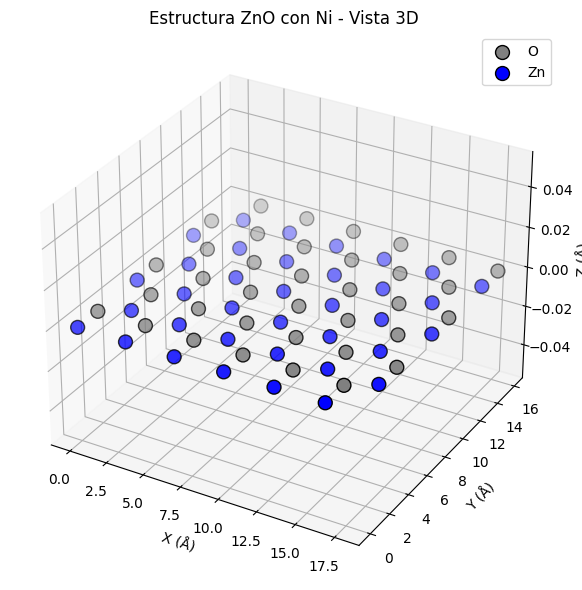

In [13]:
# Generar diccionario de coordenadas
coord_dict = {"Zn": [], "O": []}

for row in range(rows):
    y_zn = row * (a + dist_y)
    y_o = y_zn + a
    x_offset = offset_x if row % 2 == 1 else 0

    for col in range(cols):
        x = col * dist_x + x_offset
        coord_dict["Zn"].append((x, y_zn, 0))
        coord_dict["O"].append((x, y_o, 0))

positions = []
elements = []

for atom_type, coords in coord_dict.items():
    for pos in coords:
        positions.append(pos)
        elements.append(atom_type)


positions = np.array(positions)  

colors = {"Zn": "blue", "O": "grey"}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for atom_type in set(elements):
    idx = [i for i, e in enumerate(elements) if e == atom_type]
    pos = positions[idx]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
               color=colors.get(atom_type, "black"),
               label=atom_type, s=100, edgecolors='k')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Estructura ZnO con Ni - Vista 3D")
ax.legend()
plt.tight_layout()
plt.show()

# Creación de los iones que se van a adsorber

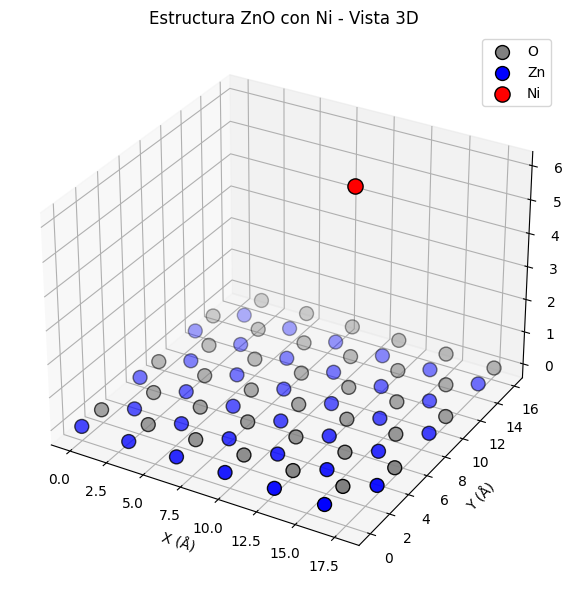

In [17]:
num_ni = 1  # número de iones Ni
z_min, z_max = 0.3 * SigmaO_Ni, 2.0 * SigmaZn_Ni  # altura en Å sobre la monocapa
radius_min, radius_max = 2.0, 5.0  # distancia lateral desde el centro

# Calcular centro de la estructura base
center = np.mean(positions, axis=0)

# Lista para almacenar posiciones de iones Ni
ni_positions = []

while len(ni_positions) < num_ni:
    direction = np.random.normal(size=2)
    direction /= np.linalg.norm(direction)
    r = np.random.uniform(radius_min, radius_max)
    x, y = center[0:2] + r * direction
    z = np.random.uniform(z_min, z_max)
    ni_positions.append([x, y, z])

ni_positions = np.array(ni_positions)


# --- Gráfica 3D Interactiva con Plotly ---
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for atom_type in set(elements):
    idx = [i for i, e in enumerate(elements) if e == atom_type]
    pos = positions[idx]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
               color=colors.get(atom_type, "black"),
               label=atom_type, s=100, edgecolors='k')
ax.scatter(ni_positions[:, 0], ni_positions[:, 1], ni_positions[:, 2],
           color='red', label='Ni', s=120, edgecolors='k')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Estructura ZnO con Ni - Vista 3D")
ax.legend()
plt.tight_layout()
plt.show()



In [ ]:
@tf.function
# Potencial de Lennard-Jones
def lennard_jones_potential(r, epsilon, sigma):
    """
    Calcula el potencial de Lennard-Jones para una distancia r.
    """
    sigma = tf.cast(sigma, tf.float32)
    epsilon = tf.cast(epsilon, tf.float32)
    lj_term = (sigma / r)**12 - (sigma / r)**6
    return 4 * epsilon * lj_term + epsilon #Suma epsilon para desplazar el fondo del potencial a 0

# Función de costo para el modelo
def H_loss(Xh, Xt, epsilon_l=Epsilon_I_L, sigma_l=Sigma_I_L, epsilon_i=Epsilon_I_I, sigma_i=Sigma_I_I, r_cutoff_I_L=r_cutoff_I_L, r_cutoff_I_I=r_cutoff_I_I):
    """
    Calcula la energía total de las interacciones entre los iones (Xh) y la superficie (Xt),
    utilizando el potencial de Lennard-Jones.

    Parameters:
        Xh: tensor con posiciones de los iones (num_iones, 3)
        Xt: tensor con posiciones de los átomos de la superficie (num_superficie, 3)

    Returns:
        Energía promedio del sistema (escalar)
    """
    #----------------------INTERACCIONES ION-NANOESTRUCTURA-------

    # Expandir dimensiones para obtener todas las combinaciones de distancias ion-atomo
    diff = tf.expand_dims(Xh, axis=1) - tf.expand_dims(Xt, axis=0)  # (num_iones, num_superficie, 2)
    r = tf.norm(diff, axis=-1)  # Distancia entre cada ion y cada átomo de la superficie (num_iones, num_superficie)

    #Eliminar los atomos muy lejanos que no interactuan
    interaction_mask = r <= r_cutoff_I_L #mascara para reducir la matriz de distacias
    #indices de las interacciones validas
    indices = tf.where(interaction_mask)  # shape: (num_valid, 2)
    ion_idx = indices[:, 0]

    valid_r = tf.gather_nd(r, indices)#distancias validas
    valid_r = tf.where(valid_r == 0, 1e-10, valid_r)# Evitar divisiones por cero

    # Calcular el potencial de Lennard-Jones para cada interacción ion atomo
    valid_energy = lennard_jones_potential(valid_r, epsilon_l, sigma_l) # (num_iones, num_superficie)

    #Suma la energia total por ion
    ion_energy_sum = tf.math.unsorted_segment_sum(valid_energy, ion_idx, tf.shape(Xh)[0])
    ion_counts = tf.math.unsorted_segment_sum(tf.ones_like(valid_energy), ion_idx, tf.shape(Xh)[0])
    ion_counts_safe = tf.where(ion_counts == 0, 1.0, ion_counts)

    # Energía promedio para cada ion y todos los atomos
    #ion_lattice_energy = ion_energy_sum / ion_counts_safe  # divide solo por los atomos que interactuaron
    ion_lattice_energy = ion_energy_sum   # Prueba sin promedio


    #----------------------INTERACCIONES ION-ION-------
    ion_indices = tf.range(tf.shape(Xh)[0]) #Define los indices que identifican a cada ion
    ion_pairs = tf.stack(tf.meshgrid(ion_indices, ion_indices, indexing='ij'),axis=-1) #Define una estructura con todas las combinaciones posibles de indices, y las combina en un tensor
    ion_pairs = tf.reshape(ion_pairs, [-1, 2])
    ion_pairs = tf.boolean_mask(ion_pairs, ion_pairs[:,0] < ion_pairs[:,1])#Filtra las parejas dubplicadas y la pareja formada consigo mismo

    diff_ion_ion = tf.gather(Xh, ion_pairs[:,0]) - tf.gather(Xh, ion_pairs[:,1])
    r_ion_ion = tf.norm(diff_ion_ion, axis=-1)
    valid_mask = r_ion_ion <= r_cutoff_I_I
    valid_pairs = tf.boolean_mask(ion_pairs, valid_mask)
    valid_r = tf.boolean_mask(r_ion_ion, valid_mask)
    valid_r = tf.where(valid_r == 0, 1e-10, valid_r)

    valid_energy = lennard_jones_potential(valid_r, epsilon_i, sigma_i)

    # Split energy between the two ions in each pair
    ion_i = valid_pairs[:,0]
    ion_j = valid_pairs[:,1]

    # Distribute energies equally to both ions
    energy_per_ion = tf.concat([valid_energy, valid_energy], axis=0)
    ion_indices_per_energy = tf.concat([ion_i, ion_j], axis=0)

    # Sum and count per ion
    ion_ion_energy_sum = tf.math.unsorted_segment_sum(energy_per_ion, ion_indices_per_energy, tf.shape(Xh)[0])
    ion_ion_counts = tf.math.unsorted_segment_sum(tf.ones_like(energy_per_ion), ion_indices_per_energy, tf.shape(Xh)[0])
    ion_ion_counts_safe = tf.where(ion_ion_counts == 0, 1.0, ion_ion_counts)

    # Per-ion average ion-ion interaction energy
    #ion_ion_energy_per_ion = ion_ion_energy_sum / ion_ion_counts_safe #Promedio de energia ion-ion por ion
    ion_ion_energy_per_ion = ion_ion_energy_sum # Prueba sin promedio

    # Devolver la energía promedio del sistema y la energía por ion
    energy_total_per_ion = ion_lattice_energy + ion_ion_energy_per_ion
    energy_total = tf.reduce_sum(energy_total_per_ion)
    return  energy_total, energy_total_per_ion

In [ ]:
#tensorflow data
ion = tf.Variable(extra_positions,dtype=tf.float32)
sample_atoms = tf.convert_to_tensor(fcc_positions,dtype=tf.float32)
#lam_LJ = 0.4
#lam_ = tf.constant(lam_LJ,dtype=tf.float32)


In [ ]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

In [ ]:
# Callback class
class EarlyStoppingCallback:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True  # Signal to stop training
        return False  # Continue training

In [ ]:
ion_ =  ion.numpy()
fig = plt.figure(figsize=(6, 6))  # Adjust figure size if needed
ax = fig.add_subplot(111, projection='3d')

ax.scatter(fcc_positions[:, 0], fcc_positions[:, 1], fcc_positions[:, 2], c='b', s=20, label='fcc_positions')
ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')

ax.set_xlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
ax.set_ylim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
ax.set_zlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()
# Custom training loop
eta0 = 1.0
batch_size = 256
epochs = 1000
decay_rate = 0.10
optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)
starting_pos =ion_.copy()
E_total_log = []#Para guardar y graficar la energía del sistema

early_stopping = EarlyStoppingCallback(patience=15, min_delta=0.0000001)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    #optimizer.learning_rate = eta
    for x_batch in tf.data.Dataset.from_tensor_slices(sample_atoms).shuffle(buffer_size=1024).batch(batch_size):

      with tf.GradientTape() as g:
        g.watch(ion)
        H_loss_,ion_total_energies= H_loss(ion,x_batch)
        E_total_log.append(float(H_loss_))
      grad_ = g.gradient(H_loss_, ion)
      optimizer.apply_gradients(zip([grad_], [ion]))
    print(f'Loss: {H_loss_.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    # Call the callback's on_epoch_end method
    """if early_stopping.on_epoch_end(epoch, H_loss_.numpy()):
        print(f'Early stopping at epoch {early_stopping.stopped_epoch + 1}')
        last_loss = H_loss_.numpy()
        system_energy = last_loss-(num_atoms*num_iones*Epsilon_I_L)
        break"""
    if epoch%15==0:
        ion_ =  ion.numpy()
        gradN = -10*eta0*grad_.numpy()
    
    
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
    
        ax.scatter(fcc_positions[:, 0], fcc_positions[:, 1], fcc_positions[:, 2], c='b', s=20, label='fcc_positions')
        ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')
    
        # For quiver, we need to create a 3D representation of the gradient
        # Assuming gradN is a 2D array (num_ions, 2)
        gradN_3D = np.zeros(gradN.shape,dtype=gradN.dtype)  # Initialize with zeros for z-component
        gradN_3D = gradN  # Copy x and y components from gradN
    
        ax.quiver(ion_[:, 0], ion_[:, 1], ion_[:, 2], gradN_3D[:, 0], gradN_3D[:, 1], gradN_3D[:, 2],
                  color='g', length=3, normalize=True, label='Gradient Vectors')  # Adjust length and normalize as needed
    
        ax.set_xlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        ax.set_ylim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        ax.set_zlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
    
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
    
        plt.show()

    if epoch+1==epochs:
      last_loss = H_loss_.numpy()
      system_energy = last_loss-(num_atoms*num_iones*Epsilon_I_L)

In [ ]:
print(f'Atomos en la muestra:{num_atoms}',f'- Iones a adsorber:{num_iones}')
print(f'Minima distancia para que no haya superposicion: {Sigma_I_L:.3f} A ',f'- Minima energía posible por ion: {-Epsilon_I_L:.3f} j/mol')
print(f'Energía promedio por ion:{system_energy/((num_atoms+num_iones)*num_iones):.3f} j/mol')
print(f"Desviación estándar de energía por ion: {tf.math.reduce_std(ion_total_energies):.3f} j/mol") #Revisar
distance=ion_-starting_pos
mean_vector = np.mean(distance, axis=0)  # Promedio en X, Y, Z
print(f'Distancia viajada promedio (vectorial): {mean_vector}')

In [ ]:
# --- Graficar evolución de energía total ---
import matplotlib.pyplot as plt
plt.plot(E_total_log)#Tiene mas puntos que epocas porque calcula una energía por batch de atomos, no se si seria mejor agrupar por epocas
plt.xlabel("Batch")
plt.ylabel("Energía total del sistema (j/mol)")
plt.title("Evolución de la energía total del sistema")
plt.grid(True)
plt.show()

In [ ]:
# --- Graficar evolución de energía total ---
import matplotlib.pyplot as plt
mean_energy = np.array(E_total_log)/((batch_size+num_iones)*num_iones)
plt.plot(mean_energy)
plt.xlabel("Batch")
plt.ylabel("Energía total del sistema (j/mol)")
plt.title("Evolución de la energía promedio del sistema")
plt.ylim(0,2)
plt.grid(True)
plt.show()

In [ ]:
# --- Gráfica 3D Interactiva con Plotly ---
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=fcc_positions[:, 0],
    y=fcc_positions[:, 1],
    z=fcc_positions[:, 2],
    mode='markers',
    marker=dict(size=2, color='blue'),
    name='Átomos FCC'
))

fig.add_trace(go.Scatter3d(
    x=ion_[:, 0],
    y=ion_[:, 1],
    z=ion_[:, 2],
    mode='markers',
    marker=dict(size=4, color='red', symbol='x'),
    name='Iones'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X (Å)',
        yaxis_title='Y (Å)',
        zaxis_title='Z (Å)'
    ),
    title='Estructura final de la nanopartícula esferica con los iones a adsorber',
    legend=dict(x=0.01, y=0.99)
)

fig.show()